In [34]:
! pip3 install --user install fuzzywuzzy PyShp geopandas rtree matplotlib

In [32]:
import pandas as pd
import io
import requests
from fuzzywuzzy import process
import shapefile
import zipfile
import json
import geopandas as gpd
import geoplot

ModuleNotFoundError: No module named 'geoplot'

In [3]:
# read intermediate canonical facilities into dataframe

intermediate_url="https://raw.githubusercontent.com/PTDP/data/main/intermediate_data/intermediate_company_facilities.csv"
intermediate = pd.read_csv(intermediate_url)

hifld_url="https://opendata.arcgis.com/datasets/2d6109d4127d458eaf0958e4c5296b67_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
hifld=pd.read_csv(hifld_url)

In [4]:
# Normalize facility google name

# uppercase
# remove entities before dash IL DOC - BIG MUDDY RIVER CORRECTIONAL CENTER

intermediate['googlePlaceName'] = intermediate['googlePlaceName'].str.upper();

#print(intermediate)
#print(hifld)

In [5]:
#ratios = process.extract(intermediate['googlePlaceName'][0],hifld['NAME'])
# def fuzzy_matches(googlePlaceName):
    

# highest = process.extractOne(intermediate['googlePlaceName'][0],hifld['NAME'])
# print(highest)

# goal - 

# geosptial join

print(hifld['NAME'][1936])

CULLMAN COUNTY DETENTION CENTER


In [6]:
# Output GeoJSON Data
hifld_shp_url="https://opendata.arcgis.com/datasets/2d6109d4127d458eaf0958e4c5296b67_0.zip?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
local_path = 'hifld.zip'

print('Downloading shapefile...')
r = requests.get(hifld_shp_url)

with open(local_path,'wb') as out: ## Open temporary file as bytes
    out.write(io.BytesIO(r.content).read())                ## Read bytes into file

# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.write(local_path)
# z.close()
print("Done")
#z.extractall(path=local_path) # extract to folder
#filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
#print(filenames)

Done


epsg:3857


<AxesSubplot:>

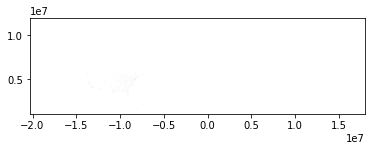

In [35]:
#print(r.content)
# hifld_geojson = shapefile.Reader(local_path + 'Prison_Boundaries.dbf').__geo_interface__
gdf_intermediate = gpd.GeoDataFrame(intermediate, geometry=gpd.points_from_xy(intermediate.longitude, intermediate.latitude))

# remove null
gdf_intermediate = gdf_intermediate[gdf_intermediate.is_valid]
# gdf_intermediate = gdf_intermediate.to_crs("EPSG:3857")
# gdf_intermediate.to_crs()

# ax = gdf_intermediate.plot()

gdf_hifld = gpd.read_file(local_path)

# sjoined_facilities = gpd.sjoin(gdf_intermediate, gdf_hifld)
# sjoined_facilities.head()

gdf_hifld.head()
print(gdf_hifld.crs)
gdf_hifld.plot()
